## Outline

1. Background
    1. Current status
1. Helper Functions # note: saved for posterity. Moved to `data_handler.py`
    1. Organize dataset
    1. Split into hour sections
    1. Split each section into X minute chunks
    1. Format results as json
    1. Save as json
1. Algorithm 1
    1. Find percent unique chatters
    1. Iterate over sections and chunks
1. Results
    1. Top 5 moments
    1. Graphs
    1. BUGS
1. Big Data EDA

# Background

__Description__:

1. Find the best moments in clips based on where the most users participated. Most is defined as the *ratio of unique users* during a 2 min section to unique users for the entire session.

__Datasets used__:

1. Big data `big_df`: 2409 rows representing one 7 hour 37 minute, 0 second twitch stream chat of [Hearthstone by LiiHS](https://www.twitch.tv/videos/955629991)
    * Used to create all algorithms

## Current status

__Finished:__
1. Algorithm 1
2. Graphing of results

__To do:__
1. ~~Clean up helper functions to be more general~~
1. Double and triple check the algorithm. Currently they don't look accurate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import json

In [3]:
from pillaralgos.helpers import data_handler as dh

# Algorithm 1

The following functions are unique to algo1

## Find percent unique chatters

In [4]:
def perc_uniques(chunk_list, min_, total_uniques, big_unique):
    '''
    Finds the percent unique chatters for each dataframe in the list. Dataframes assumed to be split using xminChats.find_rest.
    '''

    perc_unique = {
            f'{min_}min_chunk':[],
            'start':[],
            'end':[],
            'num_unique':[],
            'perc_rel_unique':[],
            'perc_abs_unique':[]
    }


    for i in range(len(chunk_list)):
        # calcuate
        chunk = i
        unique = len(chunk_list[i]['_id'].unique())
        timestamp = [chunk_list[i]['created_at'].min(), chunk_list[i]['created_at'].max()]
        perc_rel = unique/total_uniques # this is the total uniques in THAT DATAFRAME, ie the hourly cut
        perc_abs = unique/big_unique # this is the total uniques in the entire twitch session
        # store
        perc_unique[f'{min_}min_chunk'].append(chunk)
        perc_unique['start'].append(timestamp[0])
        perc_unique['end'].append(timestamp[1])
        perc_unique['num_unique'].append(unique)
        perc_unique['perc_rel_unique'].append(perc_rel)
        perc_unique['perc_abs_unique'].append(perc_abs)

    df_unique = pd.DataFrame(perc_unique)
    df_unique['elapsed'] = df_unique['end'] - df_unique['start']
    return df_unique

## Iterate over sections and chunks

NOTE: a version of this was generalized and moved to `data_handler.py`

In [5]:
def hour_iterator(big_df, min_=2, sort_by='rel'):
    '''
    Pushes all dfs in a list through the xminChats function, returns a dataframe of results
    
    input
    -----
    big_df: pd.DataFrame
        Df of the entire twitch session. This is the one that was split by dfSplitter class
    min_: int
        How long a timestamp range should be
    sort_by: str
        Whether to sort values by `abs` or `rel` unique chatters.
    '''
    ds = dh.dfSplitter(big_df) # initiate
    ds.find_rest() # split big_df into 1 hour long separate dfs
    hour_list = ds.result # result stored in class var. NOTE: index 0 is always the very first timestamp of big_df
    first_sec = hour_list[0]
    hour_list = hour_list[1:]

    # initiate empty results df
    results = pd.DataFrame(columns=['hour', f'{min_}min_chunk', 'start', 'end', 'num_unique', 'perc_rel_unique', 'perc_abs_unique'])
    max_uniques = len(big_df['_id'].unique()) # the total number of unique chatters for the entire twitch session

    # iterate all sections through the class
    for i in range(len(hour_list)):
        fm = dh.xminChats(hour_list[i], max_uniques, min_=min_)
        _n = fm.find_rest() # _n not needed
        chunk_list = fm.result # get back list of dfs, each 2 minutes long
        
        hr_uniques = perc_uniques(chunk_list, min_, total_uniques=fm.total_uniques, big_unique=fm.big_unique)
        hr_uniques['hour'] = i + 1
        results = results.append(hr_uniques)

    results['elapsed'] = results['end'] - results['start'] # to double check length
    pretty_results = results.reset_index(drop=True) # prettify
    pretty_results = pretty_results.sort_values(f'perc_{sort_by}_unique',ascending=False)
    
    json_results = dh.results_jsonified(results, first_sec, results_col=f'perc_{sort_by}_unique') # ordered by top perc_rel_unique
    
    return pretty_results, json_results

# Results

__Description__: Try to find the best moments in clips based on where the most users participated
1. ~~Isolate chat transcript to 1 hour long sessions~~ DONE `dfSplitter`
1. ~~Find total number of unique users that participated in session~~ DONE
1. ~~Find % of users that participated at any given `2 minute` timestamp~~
1. ~~Isolate `top 3` timestamps per session~~

In [6]:
sort_by = 'rel'

data = json.load(open('data/big_data.json'))
data = pd.DataFrame.from_records(data)
big_df = dh.organize_twitch_chat(data, keep_user_vars=False) # fetch appropriate data
results, json_results = hour_iterator(big_df, min_=2, sort_by=sort_by)

In [14]:
# save_json(json_results, "algo1_results")

## Top five moments

In [15]:
# for normal people
results.head()

,hour,2min_chunk,start,end,num_unique,perc_rel_unique,perc_abs_unique,elapsed
156,6,6,2021-03-27 00:52:40.290000+00:00,2021-03-27 00:54:40.127000+00:00,421,0.266119,0.043433,0 days 00:01:59.837000
201,7,21,2021-03-27 02:22:44.867000+00:00,2021-03-27 02:24:44.753000+00:00,510,0.262211,0.052615,0 days 00:01:59.886000
100,4,10,2021-03-26 23:00:47.031000+00:00,2021-03-26 23:02:46.853000+00:00,284,0.232216,0.029299,0 days 00:01:59.822000
291,10,21,2021-03-27 05:22:54.723000+00:00,2021-03-27 05:24:53.251000+00:00,480,0.223152,0.049520,0 days 00:01:58.528000
226,8,16,2021-03-27 03:12:44.743000+00:00,2021-03-27 03:14:44.730000+00:00,446,0.217455,0.046013,0 days 00:01:59.987000


[Twitch Source](https://www.twitch.tv/videos/955629991)

Variables:
* `hour`: section of twitch chat df, after df was split into 1 hour sections
* `xmin_chunk`: chunk of hour section, after section was split into x min chunks
* `start`: starting timestamp of chunk
* `end`: ending timestamp of chunk
* `num_unique`: number of unique chatters in that chunk
* `perc_rel_unique`: percent of unique __hour section__ chatters participating in that chunk
* `perc_abs_unique`: percent of unique __twitch df__ chatters participating in that chunk

__Conclusion__: The max relative chat engagement was around 55% in the eighth hour of twitch chat during chunk_16. Timestamps `03-20 05:32` to `03-20 05:33` are good candidates

In [17]:
# for engineers
json_results[:8]

[{'startTime': 18725.355, 'endTime': 18845.192},
 {'startTime': 24129.932, 'endTime': 24249.818},
 {'startTime': 12012.096, 'endTime': 12131.918},
 {'startTime': 34939.788, 'endTime': 35058.316},
 {'startTime': 27129.808, 'endTime': 27249.795},
 {'startTime': 36245.123, 'endTime': 36364.36},
 {'startTime': 27490.397, 'endTime': 27610.244},
 {'startTime': 27250.118, 'endTime': 27369.878}]

## Graphs

/home/jupyter-pomkos/.conda/envs/pillar_env/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent chatters, relative to each hour')

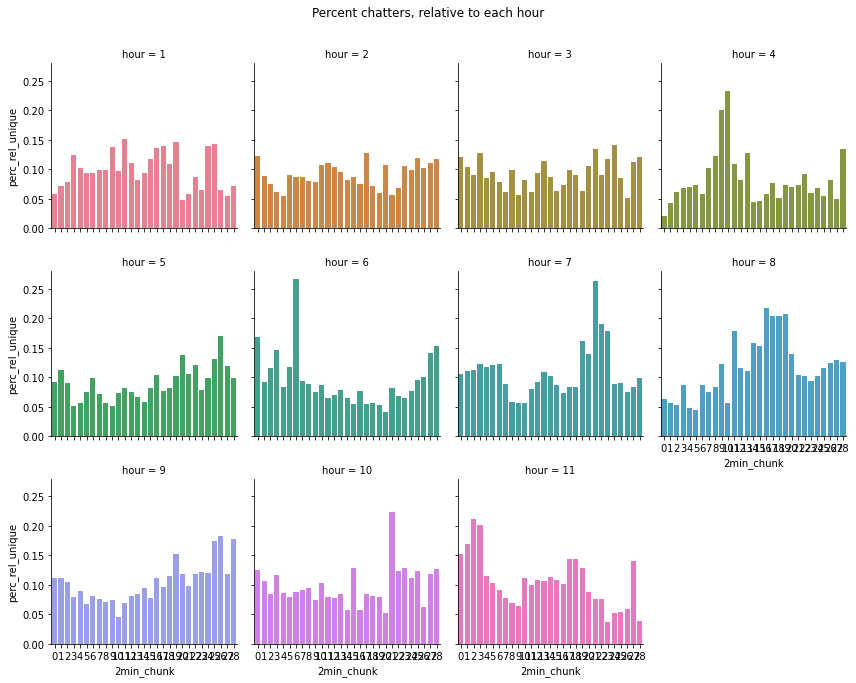

In [18]:
g = sns.FacetGrid(results,col='hour', col_wrap = 4, hue = 'hour')
g.map(sns.barplot,'2min_chunk','perc_rel_unique')

plt.suptitle("Percent chatters, relative to each hour",y=1.05)

/home/jupyter-pomkos/.conda/envs/pillar_env/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Percent of total twitch session chatters participating at each chunk')

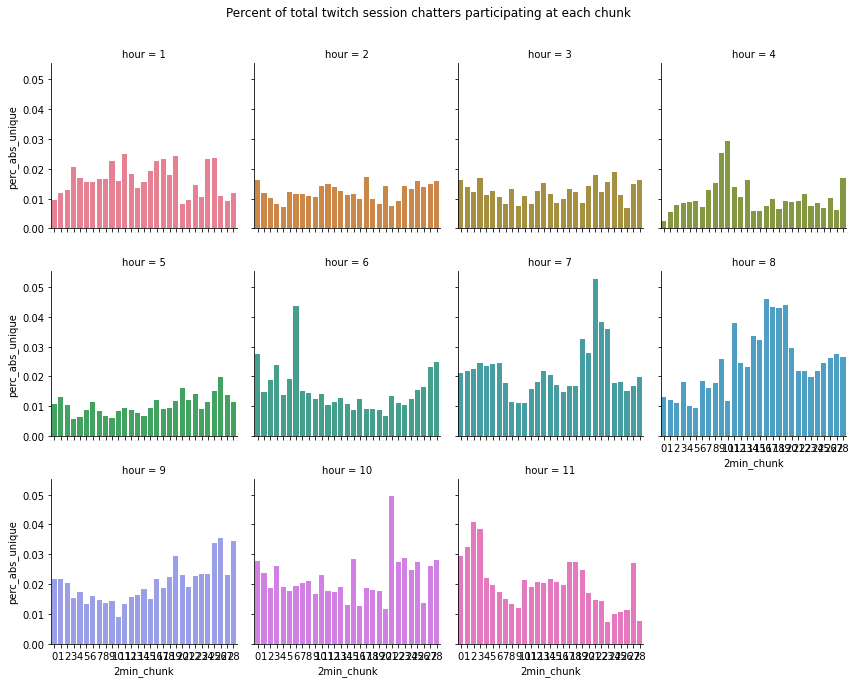

In [19]:
g = sns.FacetGrid(results,col='hour', col_wrap = 4, hue = 'hour')
g.map(sns.barplot,'2min_chunk','perc_abs_unique')

plt.suptitle("Percent of total twitch session chatters participating at each chunk",y=1.05)

## BUGS

Why do the perc_abs_unique and perc_rel_unique have the same exact graphs???

# Big Data EDA

[Twitch Source](https://www.twitch.tv/videos/955629991)

In [21]:
data = json.load(open('data/big_data.json'))

In [22]:
data = pd.DataFrame.from_records(data)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103928 entries, 0 to 103927
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   _id                     103928 non-null  object 
 1   created_at              103928 non-null  object 
 2   updated_at              103928 non-null  object 
 3   channel_id              103928 non-null  object 
 4   content_type            103928 non-null  object 
 5   content_id              103928 non-null  object 
 6   content_offset_seconds  103928 non-null  float64
 7   commenter               103928 non-null  object 
 8   source                  103928 non-null  object 
 9   state                   103928 non-null  object 
 10  message                 103928 non-null  object 
dtypes: float64(1), object(10)
memory usage: 8.7+ MB


In [25]:
big_df = organize_twitch_chat(data) # fetch appropriate data

Text(0.5, 1.0, 'Message Count')

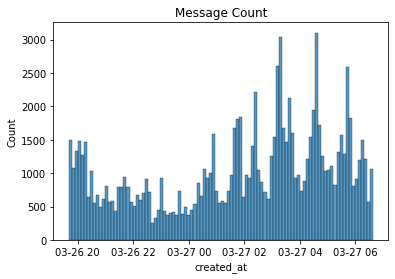

In [26]:
sns.histplot(big_df['created_at'], bins=100)
plt.title("Message Count")

In [ ]:
sns.histplot(big_df['display_name'])
plt.title("Messages per User")